In [1153]:
import requests, re
from bs4 import BeautifulSoup as bs
import pandas as pd
from selenium import webdriver
from selenium.webdriver.chrome.options import Options
import time, random
from urllib.request import urlopen
import urllib.parse
import numpy as np
from IPython.display import display
import datetime
import Levenshtein as lev
from itertools import product
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LinearRegression, Lasso, LassoCV, Ridge, RidgeCV
from sklearn.metrics import r2_score
import statsmodels.api as sm
from sklearn.preprocessing import StandardScaler
%matplotlib inline

The goal of this project is to predict a book's demand on Overdrive (an ebook hosting service for public libraries) based on the book's publication date, popularity, author reputation, and numerous other factors.

Import data set for books for which data exist for number of people who requested the book or have it checked out.

In [283]:
def print_full(x):
    pd.set_option('display.max_rows', None)
    pd.set_option('display.max_columns', None)
    pd.set_option('display.width', 2000)
    pd.set_option('display.float_format', '{:20,.2f}'.format)
    pd.set_option('display.max_colwidth', None)
    print(x)
    pd.reset_option('display.max_rows')
    pd.reset_option('display.max_columns')
    pd.reset_option('display.width')
    pd.reset_option('display.float_format')
    pd.reset_option('display.max_colwidth')
    
def full_print(x):
    return print_full(x)

In [1242]:
# df = pd.read_csv('Figures/merged_df_lev_cleaned.csv', index_col = 0)
df = pd.read_csv('Figures/merged_df_lev_cleaned.csv', index_col = 0)

## Further Cleaning
Make sure the book on Overdrive and the one on Goodreads match by measuring the Levenshtein ratio between the books' authors.

In [1243]:
df = df[df.author_ratings != -1.0]

Clean up data to convert it to ints and floats from the raw form it came in from the websites.

In [1244]:
df['People waiting per copy'] = df['People waiting per copy'].apply(lambda x: x.replace('<', '')).astype('int')

In [1245]:
df[['Library copies', 'People waiting in total']] = df[['Library copies', 'People waiting in total']].astype('int').copy()

In [1246]:
df.is_movie = df.is_movie.fillna('False')

In [1247]:
df[['is_series', 'is_movie']] = df[['is_series', 'is_movie']].replace({'True': 1, 'False': 0}).replace({True: 1, False: 0})

In [1248]:
# df['demand'] = np.nan
df['demand'] = df.apply(lambda x: x['Library copies'] + x['People waiting in total'], axis=1)

Text(0, 0.5, 'Demand')

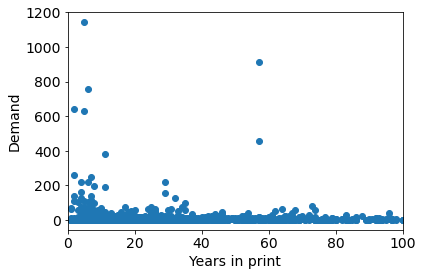

In [1249]:
plt.scatter(df['age'], df['demand'])
ax = plt.gca()
ax.set_xlim(0,100)
plt.xlabel('Years in print')
plt.ylabel('Demand')
# ax.set_ylim(0, 50)

Looks like more recent books do have more demand. There are a few recent outliers.

In [1250]:
len(df[df.demand>200])

12

Looking at the outliers below, it is possible they are outliers because a movie has come out recently, or a school has assigned a particular book to be read.

In [1251]:
df[df.demand>300][['title', 'Library copies', 'People waiting in total']]

,title,Library copies,People waiting in total
20,The Seven Husbands of Evelyn Hugo,223,920
22,The Seven Husbands of Evelyn Hugo,64,564
119,It Ends with Us,135,624
3129,The Song of Achilles,57,325
4000,Dune,170,746
4002,Dune,106,352
4302,The Midnight Library,385,256


Looking at the pairplot for a book and author popularity, it appears as if the data are a mess with several outliers.

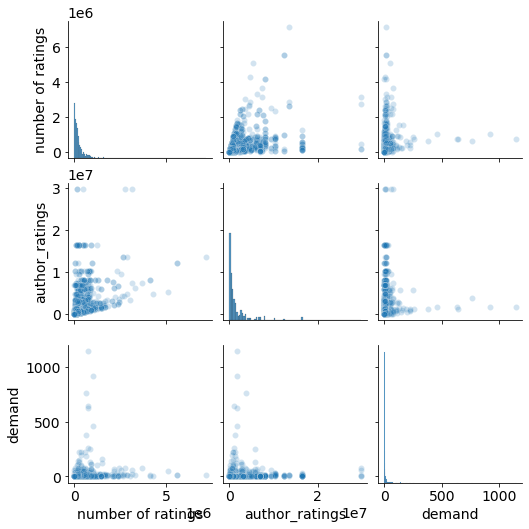

In [1252]:
# sns.pairplot(df[['number of ratings', 'author_ratings', 'demand']])
sns.pairplot(df[['number of ratings', 'author_ratings', 'demand']], kind='scatter', plot_kws={'alpha':0.2})

Demand appears similar across media types (ebook vs. audiobook)

Clean up price info.

In [1254]:
df.price = df.price.str.extract("(\d*\.\d+)", expand=True).apply(pd.to_numeric)

In [1255]:
df.price.fillna(0, inplace=True)

In [1256]:
df.price = df.price.astype('float')

Convert media type category (ebook vs. audiobook) to dummy variable

In [1257]:
try: 
    is_ebook = df.media.replace({'ebook': 1, 'Audiobook': 0})
except: pass
try: df.insert(15, 'is_ebook', is_ebook) 
except: pass
df.drop('media', axis=1, inplace=True, errors='ignore')

In [1258]:
df.is_ebook = is_ebook.replace({'Video': np.nan})

Remove movies whose Levenshtein scores for movie title are below 90%.

In [1259]:
df.is_movie.loc[df.LevScore_IMDB < 0.9] = 0

/opt/anaconda3/envs/metis/lib/python3.9/site-packages/pandas/core/indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)


In [1260]:
numerics = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']
sub_df = df.select_dtypes(include=numerics)

In [1261]:
list(sub_df.columns)

['id_number',
 'stars',
 'number of ratings',
 'is_series',
 'year_published',
 'price',
 'number of pages',
 'is_movie',
 'movie year',
 'is_ebook',
 'Library copies',
 'People waiting in total',
 'People waiting per copy',
 'author_stars',
 'author_ratings',
 'author_num_reviews',
 'author_distinct_works',
 'LevScore',
 'age',
 'LevScore_updated',
 'LevScore_IMDB',
 'Beginning Reader',
 'Finance',
 'Nature',
 'Economics',
 'Non-English Fiction',
 'Mathematics',
 'Politics',
 'Humor (Fiction)',
 'Historical Fiction',
 'History',
 'Family & Relationships',
 'Biography & Autobiography',
 'New Age',
 'Mythology',
 'Science Fiction & Fantasy',
 'Short Stories',
 'Business',
 'Literature',
 'LGBTQIA+ (Fiction)',
 'Literary Criticism',
 'Writing',
 'Science',
 'Stage Production',
 'Nonfiction',
 'African American Fiction',
 'Transportation',
 'Self-Improvement',
 'Psychology',
 'Thriller',
 'Self Help',
 'Juvenile Literature',
 'Western',
 'Classic Literature',
 'Entertainment',
 'Literary 

Drop the 'title not found' column. Not sure how that got in there. Also drop one of the genre dummy variables. Let's say "Poetry" so that poetry will be the intercept of the LR equation.

In [1262]:
df.drop(['title not found', 'Poetry'], axis=1, inplace=True, errors='ignore')

Run linear regression on everything.

In [1263]:
X = sub_df.drop(['demand', 'id_number'], axis=1)
#define explanatory variable
y = sub_df['demand']

#add constant to predictor variables
X = sm.add_constant(X)

#fit linear regression model
model = sm.OLS(y, X, missing='drop').fit()

#view model summary
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:                 demand   R-squared:                       1.000
Model:                            OLS   Adj. R-squared:                  1.000
Method:                 Least Squares   F-statistic:                 2.796e+25
Date:                Mon, 24 Jan 2022   Prob (F-statistic):               0.00
Time:                        19:37:50   Log-Likelihood:                 19962.
No. Observations:                 867   AIC:                        -3.978e+04
Df Residuals:                     793   BIC:                        -3.942e+04
Df Model:                          73                                         
Covariance Type:            nonrobust                                         
                                  coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------------
const             

The model has overfit everything. Let's reduce model complexity and hopefully get more accurate results. <br> Sort genres by total, select for top-6 to reduce number of dummy variables while keeping non-fiction included.

In [1277]:
# print(list(zip(df.isnull().sum().index, df.isnull().sum())))
nulls = sub_df.isnull().sum()
nulls[nulls > 0]

year_published     28
movie year        941
is_ebook            7
age                28
dtype: int64

In [1278]:
sub_df = sub_df.fillna(0)
X = sub_df.drop(['demand', 'id_number'], axis=1)
#define explanatory variable
y = sub_df['demand']

#add constant to predictor variables
X = sm.add_constant(X)

In [1280]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

alphas = 10**np.linspace(-2,2,200)
lasso_model = LassoCV(alphas = alphas, cv=5)
lasso_model.fit(X_train, y_train)
r_squared_train = lasso_model.score(X_train, y_train)
r_squared_test = lasso_model.score(X_test, y_test)
alpha = lasso_model.alpha_

print(r_squared_train)
print(r_squared_test)
print(alpha)

0.999998198486245
0.9999998667332312
0.01


Try scaling.

In [1281]:
std = StandardScaler()
std.fit(X.values)
## apply the scaler to the train set
X_scaled = std.transform(X.values)

In [1282]:
X_scaled = pd.DataFrame(X_scaled, columns = X.columns)

In [1283]:
X_scaled.drop('const', axis=1, inplace=True, errors='ignore')

In [1284]:
X_scaled.index = X.index

In [1285]:
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2)

alphas = 10**np.linspace(-2,2,200)
lasso_model = LassoCV(alphas = alphas, cv=5)
lasso_model.fit(X_train, y_train)
r_squared_train = lasso_model.score(X_train, y_train)
r_squared_test = lasso_model.score(X_test, y_test)
alpha = lasso_model.alpha_

print(r_squared_train)
print(r_squared_test)
print(alpha)

0.9999999011498513
0.999999905117665
0.01


In [1286]:
lasso_model.coef_

array([ 0.        ,  0.        , -0.        ,  0.        ,  0.        ,
       -0.        ,  0.        , -0.        ,  0.        , 33.13305945,
       46.14442342,  0.        ,  0.        ,  0.        ,  0.        ,
       -0.        ,  0.        , -0.        ,  0.        ,  0.        ,
       -0.        ,  0.        , -0.        ,  0.        , -0.        ,
        0.        , -0.        ,  0.        ,  0.        , -0.        ,
       -0.        , -0.        , -0.        , -0.        , -0.        ,
       -0.        ,  0.        ,  0.        ,  0.        , -0.        ,
        0.        ,  0.        ,  0.        , -0.        ,  0.        ,
       -0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
       -0.        , -0.        ,  0.        ,  0.        , -0.        ,
       -0.        ,  0.        , -0.        , -0.        ,  0.        ,
       -0.        , -0.        , -0.        , -0.        , -0.        ,
       -0.        , -0.        , -0.        , -0.        ,  0.  

In [1240]:
#define response variable
# X_pop = sub_df_pop.drop('demand', axis=1)
#define explanatory variable
y_pop = sub_df_pop['demand']

#add constant to predictor variables
X_scaled_pop = sm.add_constant(X_scaled_pop)

#fit linear regression model
model = sm.OLS(y_pop, X_scaled_pop, missing='drop').fit()

#view model summary
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:                 demand   R-squared:                       0.134
Model:                            OLS   Adj. R-squared:                  0.128
Method:                 Least Squares   F-statistic:                     22.72
Date:                Sun, 23 Jan 2022   Prob (F-statistic):           1.85e-47
Time:                        16:05:25   Log-Likelihood:                -6670.1
No. Observations:                1772   AIC:                         1.337e+04
Df Residuals:                    1759   BIC:                         1.344e+04
Df Model:                          12                                         
Covariance Type:            nonrobust                                         
                          coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------
const                   6.0406    

In [535]:
sorted_genres = df.iloc[:,31:].sum().sort_values(ascending=False)[1:]
print(sorted_genres[:6])
list_sorted_genres = list(sorted_genres.index)
# list_sorted_genres

Fiction                1592
Literature              954
Fantasy                 488
Young Adult Fiction     364
Romance                 347
Nonfiction              227
dtype: int64


In [537]:
genres_to_drop = list_sorted_genres[6:]
# genres_to_drop

In [538]:
sub_df.drop(df.loc[:,genres_to_drop], axis=1, inplace=True, errors='ignore')

/opt/anaconda3/envs/metis/lib/python3.9/site-packages/pandas/core/frame.py:4906: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().drop(


In [539]:
sub_df['movie_age'] = 2022 - sub_df['movie year']

/var/folders/b1/x16nkyxn74s8p16m4l_9dqh00000gn/T/ipykernel_68873/151484995.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sub_df['movie_age'] = 2022 - sub_df['movie year']


In [542]:
sub_df.drop(columns=['year_published','title not found', 'id_number', 'movie year', 'People waiting per copy', 'LevScore', 'LevScore_updated'], inplace=True, errors='ignore')

In [543]:
sub_df.columns

Index(['stars', 'number of ratings', 'is_series', 'price', 'number of pages',
       'is_movie', 'is_ebook', 'Library copies', 'People waiting in total',
       'author_stars', 'author_ratings', 'author_num_reviews',
       'author_distinct_works', 'age', 'LevScore_IMDB', 'Literature',
       'Nonfiction', 'Young Adult Fiction', 'Romance', 'Fiction', 'Fantasy',
       'Poetry', 'demand', 'movie_age'],
      dtype='object')

In [545]:
len(sub_df[sub_df.LevScore_IMDB > 0.9])

713

The number of books with accurate information on whether it was converted to a movie is too small to do any analysis on. Additionally, some books have simple titles that match movie titles purely by coincidence. Scraping IMDB by searching a book's title is likely not an ideal way to obtain this information.

In [547]:
sub_df.drop(['LevScore_IMDB', 'is_movie'], axis=1, inplace=True, errors='ignore')

/opt/anaconda3/envs/metis/lib/python3.9/site-packages/pandas/core/frame.py:4906: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().drop(


<AxesSubplot:>

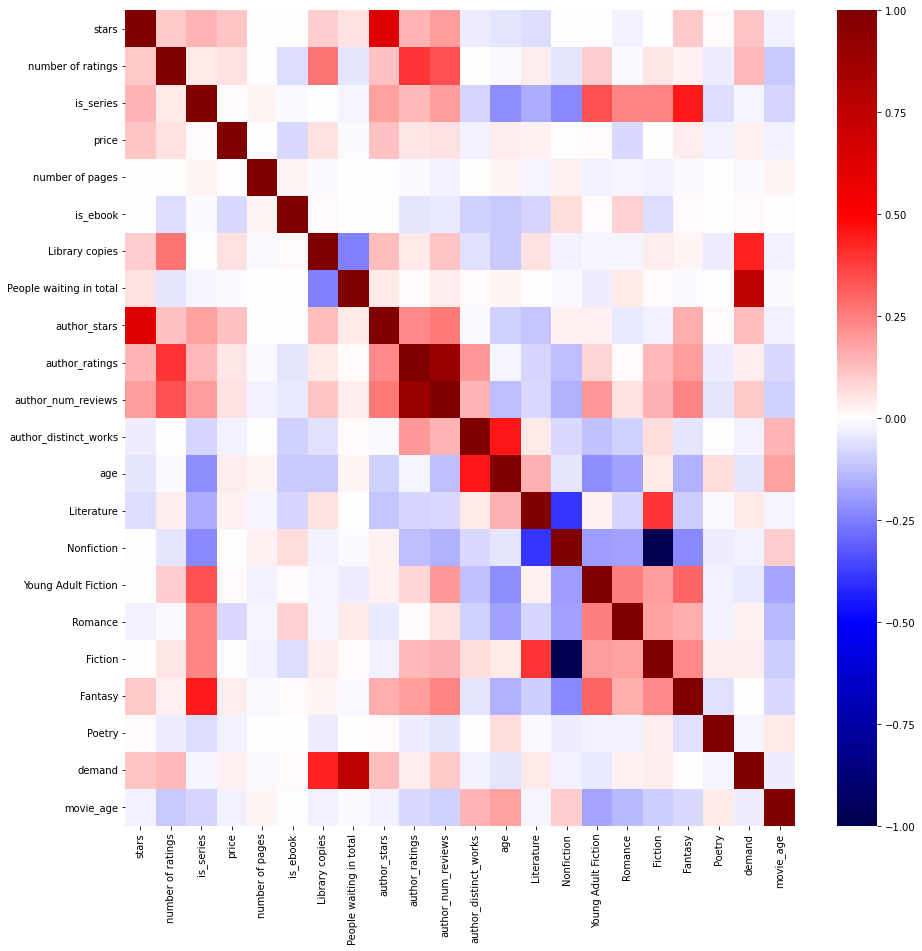

In [552]:
fig, ax = plt.subplots(figsize=(15, 15))

sns.heatmap(sub_df.corr(), cmap="seismic", vmin=-1, vmax=1, ax=ax)

In [548]:
sub_df.columns

Index(['stars', 'number of ratings', 'is_series', 'price', 'number of pages',
       'is_ebook', 'Library copies', 'People waiting in total', 'author_stars',
       'author_ratings', 'author_num_reviews', 'author_distinct_works', 'age',
       'Literature', 'Nonfiction', 'Young Adult Fiction', 'Romance', 'Fiction',
       'Fantasy', 'Poetry', 'demand', 'movie_age'],
      dtype='object')

Remove outliers. Try repeating the linear regression using data normalized by age.

In [627]:
sub_df_norm.demand.sort_values(ascending=False).head(30)

20      1143
4000     916
119      759
4302     641
22       628
4002     458
3129     382
4303     257
397      251
5140     222
2844     222
4706     219
4817     194
3131     188
2786     163
4707     154
4246     140
399      136
4695     129
2784     124
69       117
4842     110
4401     110
5081     106
5141     104
389      100
3409      99
4014      79
2846      77
1114      77
Name: demand, dtype: int64

In [629]:
sub_df_norm = sub_df_norm[sub_df_norm.demand < 100]

In [619]:
sub_df_norm = sub_df.copy()

In [662]:
sub_df_norm['number of ratings (norm)'] = sub_df_norm['number of ratings'] / sub_df_norm['age']
# sub_df_norm['author_ratings (norm)'] = sub_df_norm['author_ratings'] / sub_df_norm['age']
sub_df_norm.drop('author_ratings (norm)', axis=1, inplace=True, errors='ignore')

In [1112]:
sub_df_norm['popularity'] = sub_df_norm['stars'] * sub_df_norm['number of ratings'] / sub_df_norm['age']

<Figure size 648x504 with 0 Axes>

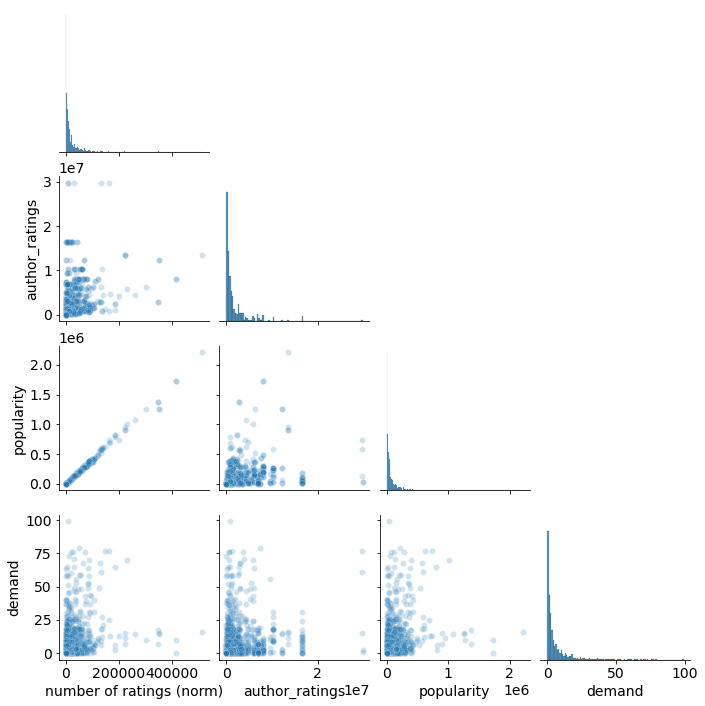

In [1113]:
plt.figure(figsize=(9,7))
sns.pairplot(sub_df_norm[['number of ratings (norm)', 'author_ratings','popularity', 'demand']], kind='scatter', plot_kws={'alpha':0.2}, 
             corner=True)

In [1114]:
X = sub_df_norm['popularity'][sub_df_norm['popularity'] < float('inf')]
X.sort_values(ascending=False)


3754    2.212400e+06
3791    1.733311e+06
3793    1.733311e+06
279     1.372912e+06
277     1.372912e+06
            ...     
3499    0.000000e+00
4627    0.000000e+00
2718   -2.222222e-02
5067   -1.500000e-01
499    -4.444444e-01
Name: popularity, Length: 1772, dtype: float64

In [1115]:
# pd.DataFrame(X)
X = pd.DataFrame(np.array(X).reshape(-1,1), columns = ['number of ratings (norm)'])
X

,number of ratings (norm)
0,70770.736061
1,70770.736061
2,17816.818182
3,17816.818182
4,40064.467368
...,...
1767,203758.687500
1768,124642.771429
1769,2984.741081
1770,1.998000


In [1116]:
X.fillna(0, inplace=True)
y = sub_df_norm.demand[sub_df_norm['number of ratings (norm)'] < float('inf')]
y.fillna(0, inplace=True)
lr = LinearRegression()
lr.fit(X, y)
lr.score(X,y)

0.09498667709424857

In [1117]:
X.shape

(1772, 1)

In [1118]:
X.max()

number of ratings (norm)    2.212400e+06
dtype: float64

In [1119]:
# X = sub_df_norm[['number of ratings (norm)']]
# X['const'] = 1.0
# X = X.reshape(-1,1)
X.fillna(0, inplace=True)
y = sub_df_norm.demand[sub_df_norm['number of ratings (norm)'] < float('inf')]
y.fillna(0, inplace=True)
lr = LinearRegression()
lr.fit(X, y)
lr.score(X,y)

0.09498667709424857

linear r2 = 0.09498667709424857
poly r2 = 0.14841123514522003


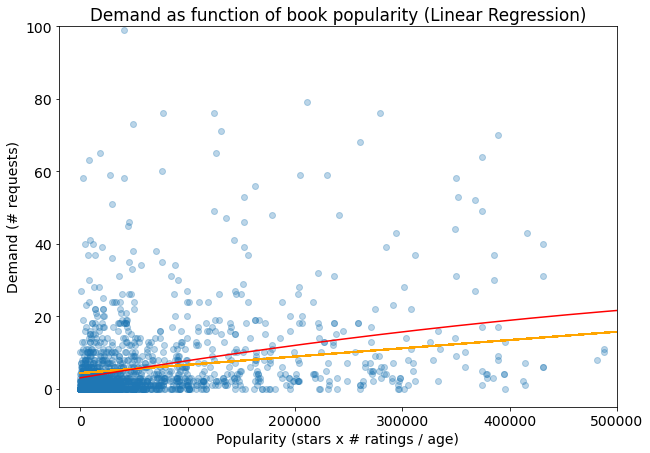

In [1126]:
poly_reg = PolynomialFeatures(degree=2)
X_poly = poly_reg.fit_transform(X)
lin_reg2 = LinearRegression()
lin_reg2.fit(X_poly,y)
 
X_grid = np.arange(float(X.min()), float(X.max()),0.1)
X_grid = X_grid.reshape(len(X_grid),1) 
plt.figure(figsize=(10, 7))
plt.rc('font', size=14)
plt.scatter(X,y, alpha=0.3) 

lin_reg3 = LinearRegression()
lin_reg3.fit(X, y)
print(f'linear r2 = {lin_reg3.score(X,y)}')
print(f'poly r2 = {lin_reg2.score(X_poly,y)}')
plt.plot(X,lin_reg3.predict(X),color='orange')
 
plt.plot(X_grid, lin_reg2.predict(poly_reg.fit_transform(X_grid)),color='red') 
ax = plt.gca().set_xlim(-20000, 500000)
ax = plt.gca().set_ylim(-5, 100)
 
plt.title('Demand as function of book popularity (Linear Regression)')
plt.xlabel('Popularity (stars x # ratings / age)')
plt.ylabel('Demand (# requests)')
plt.show()

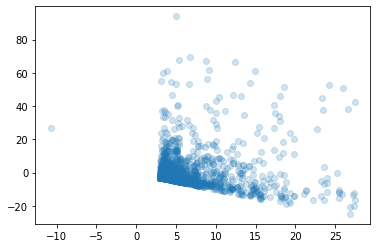

In [1190]:
# Residual plot for the 2D linear regression above.
y_pred = lin_reg2.predict(X_poly)
resid = y - y_pred

plt.scatter(y_pred, resid, alpha=0.2)


Repeat linear regression using 'population' defined as stars * ratings / age and remove other time-dependent features.

In [1231]:
sub_df_pop = sub_df_norm.copy()

In [1232]:
sub_df_pop.columns

Index(['stars', 'number of ratings', 'is_series', 'price', 'number of pages',
       'is_ebook', 'Library copies', 'People waiting in total', 'author_stars',
       'author_ratings', 'author_num_reviews', 'author_distinct_works', 'age',
       'Literature', 'Nonfiction', 'Young Adult Fiction', 'Romance', 'Fiction',
       'Fantasy', 'Poetry', 'demand', 'movie_age', 'number of ratings (norm)',
       'popularity'],
      dtype='object')

In [1233]:
sub_df_pop = sub_df_pop[['popularity', 'is_series', 'price', 'number of pages', 'is_ebook', 'Literature', 'Nonfiction', 'Young Adult Fiction', 'Romance', 'Fiction',
       'Fantasy', 'Poetry', 'demand']]

In [1234]:
sub_df_pop = sub_df_pop[sub_df_pop.popularity != float('inf')]

In [1235]:
#define response variable
X_pop = sub_df_pop.drop('demand', axis=1)
#define explanatory variable
y_pop = sub_df_pop['demand']

#add constant to predictor variables
X_pop = sm.add_constant(X_pop)

#fit linear regression model
model = sm.OLS(y_pop, X_pop, missing='drop').fit()

#view model summary
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:                 demand   R-squared:                       0.134
Model:                            OLS   Adj. R-squared:                  0.128
Method:                 Least Squares   F-statistic:                     22.72
Date:                Sun, 23 Jan 2022   Prob (F-statistic):           1.85e-47
Time:                        16:05:15   Log-Likelihood:                -6670.1
No. Observations:                1772   AIC:                         1.337e+04
Df Residuals:                    1759   BIC:                         1.344e+04
Df Model:                          12                                         
Covariance Type:            nonrobust                                         
                          coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------
const                  -1.0111    

Scale data

In [1236]:
std = StandardScaler()
std.fit(X_pop.values)
## apply the scaler to the train set
X_scaled_pop = std.transform(X_pop.values)

In [1237]:
X_scaled_pop = pd.DataFrame(X_scaled_pop, columns = X_pop.columns)

In [1238]:
X_scaled_pop.drop('const', axis=1, inplace=True, errors='ignore')

In [1239]:
X_scaled_pop.index = X_pop.index

In [1240]:
#define response variable
# X_pop = sub_df_pop.drop('demand', axis=1)
#define explanatory variable
y_pop = sub_df_pop['demand']

#add constant to predictor variables
X_scaled_pop = sm.add_constant(X_scaled_pop)

#fit linear regression model
model = sm.OLS(y_pop, X_scaled_pop, missing='drop').fit()

#view model summary
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:                 demand   R-squared:                       0.134
Model:                            OLS   Adj. R-squared:                  0.128
Method:                 Least Squares   F-statistic:                     22.72
Date:                Sun, 23 Jan 2022   Prob (F-statistic):           1.85e-47
Time:                        16:05:25   Log-Likelihood:                -6670.1
No. Observations:                1772   AIC:                         1.337e+04
Df Residuals:                    1759   BIC:                         1.344e+04
Df Model:                          12                                         
Covariance Type:            nonrobust                                         
                          coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------
const                   6.0406    

Try lasso regression but probably won't help given the low R-squared.

In [1186]:
X_train, X_test, y_train, y_test = train_test_split(X_scaled_pop, y_pop, test_size=0.2)

alphas = 10**np.linspace(-2,2,200)
lasso_model = LassoCV(alphas = alphas, cv=5)
lasso_model.fit(X_train, y_train)
r_squared_train = lasso_model.score(X_train, y_train)
r_squared_test = lasso_model.score(X_test, y_test)
alpha = lasso_model.alpha_

print(r_squared_train)
print(r_squared_test)
print(alpha)

0.13220257962459314
0.11703038569897461
0.16831803533309567


Lasso regression doesn't really do anything.

Text(0.5, 1.0, 'Residual plot for multiple linear regression model')

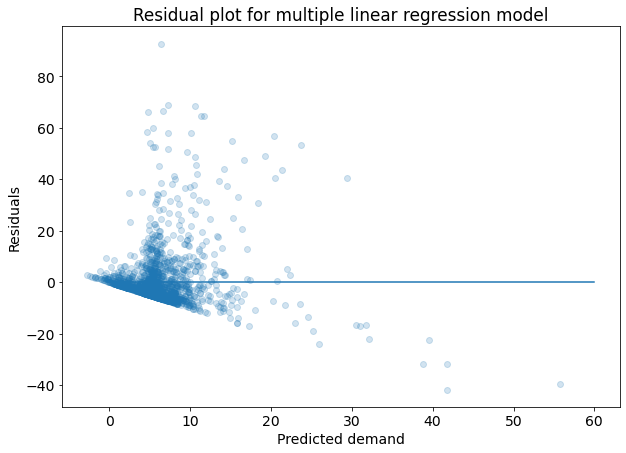

In [1194]:
y_pred = model.predict(X_scaled_pop)
resid = y - y_pred
plt.figure(figsize=(10, 7))
plt.rc('font', size=14)
plt.scatter(y_pred, resid, alpha=0.2)
plt.plot([0,60], [0,0])
plt.ylabel('Residuals')
plt.xlabel('Predicted demand')
plt.title('Residual plot for multiple linear regression model')


Try reducing residuals by fitting the log(demand) instead. This helps.

In [1210]:
y_pop = sub_df_pop['demand'].apply(lambda x: np.log(x))
y_pop = y_pop.replace(float('-inf'), 0)
# y_pop[y_pop == float('-inf')]
#add constant to predictor variables
X_scaled_pop = sm.add_constant(X_scaled_pop)

#fit linear regression model
model = sm.OLS(y_pop, X_scaled_pop, missing='drop').fit()

#view model summary
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:                 demand   R-squared:                       0.181
Model:                            OLS   Adj. R-squared:                  0.176
Method:                 Least Squares   F-statistic:                     32.47
Date:                Sun, 23 Jan 2022   Prob (F-statistic):           3.37e-68
Time:                        14:27:54   Log-Likelihood:                -2613.5
No. Observations:                1772   AIC:                             5253.
Df Residuals:                    1759   BIC:                             5324.
Df Model:                          12                                         
Covariance Type:            nonrobust                                         
                          coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------
const                   1.0240    

linear r2 = 0.11569644602657325
poly r2 = 0.17572613232171752


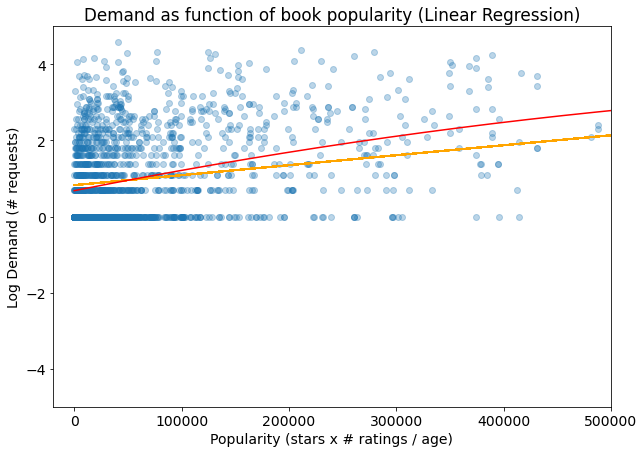

In [1213]:
poly_reg = PolynomialFeatures(degree=2)
X_poly = poly_reg.fit_transform(X)
lin_reg2 = LinearRegression()
lin_reg2.fit(X_poly,y_pop)
 
X_grid = np.arange(float(X.min()), float(X.max()),0.1)
X_grid = X_grid.reshape(len(X_grid),1) 
plt.figure(figsize=(10, 7))
plt.rc('font', size=14)
plt.scatter(X,y_pop, alpha=0.3) 

lin_reg3 = LinearRegression()
lin_reg3.fit(X, y_pop)
print(f'linear r2 = {lin_reg3.score(X,y_pop)}')
print(f'poly r2 = {lin_reg2.score(X_poly,y_pop)}')
plt.plot(X,lin_reg3.predict(X),color='orange')
 
plt.plot(X_grid, lin_reg2.predict(poly_reg.fit_transform(X_grid)),color='red') 
ax = plt.gca().set_xlim(-20000, 500000)
ax = plt.gca().set_ylim(-5, 5)
 
plt.title('Demand as function of book popularity (Linear Regression)')
plt.xlabel('Popularity (stars x # ratings / age)')
plt.ylabel('Log Demand (# requests)')
plt.show()

Text(0.5, 1.0, 'Residual plot for multiple linear regression model')

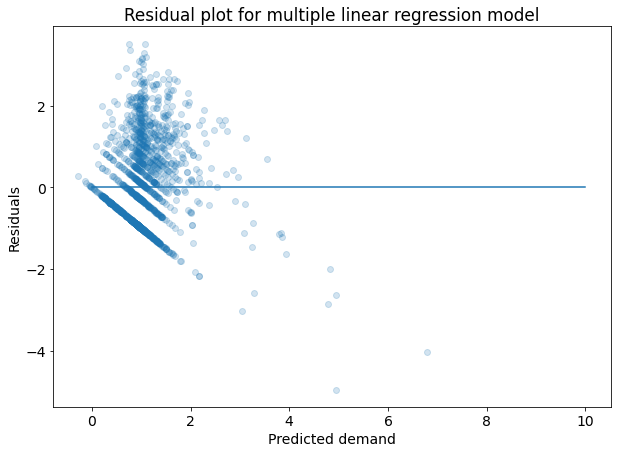

In [1215]:
y_pred = model.predict(X_scaled_pop)
resid = y_pop - y_pred
plt.figure(figsize=(10, 7))
plt.rc('font', size=14)
plt.scatter(y_pred, resid, alpha=0.2)
plt.plot([0,10], [0,0])
plt.ylabel('Residuals')
plt.xlabel('Predicted demand')
plt.title('Residual plot for multiple linear regression model')


In [1216]:
len(y)

1772

In [1218]:
sub_df_norm.groupby('is_ebook').demand.count()

is_ebook
0.0     786
1.0    1014
Name: demand, dtype: int64

In [1219]:
sub_df_norm.groupby('is_ebook').demand.sum()

is_ebook
0.0    4709
1.0    6051
Name: demand, dtype: int64

In [1220]:
sub_df_norm.groupby('is_ebook').demand.sum()/sub_df_norm.groupby('is_ebook').demand.count()

is_ebook
0.0    5.991094
1.0    5.967456
Name: demand, dtype: float64

Equal demand for audio and ebooks.

Lasso Regression is useless here

(0.0, 60000.0)

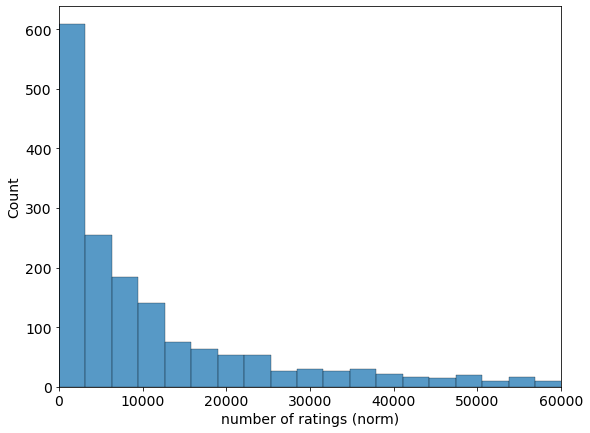

In [972]:
plt.figure(figsize=(9,7))
plt.rc('font', size=14)
sns.histplot(data=sub_df_num_ratings, x='number of ratings (norm)')
plt.gca().set_xlim(0, 0.06E6)

Text(0.5, 0, 'Number of ratings')

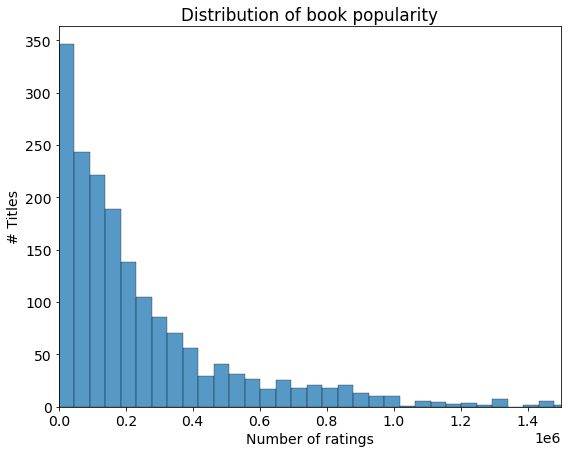

In [1134]:
plt.figure(figsize=(9,7))
plt.rc('font', size=14)
sns.histplot(data=sub_df_num_ratings, x='number of ratings')
plt.gca().set_xlim(0, 1.5E6)
plt.title('Distribution of book popularity')
plt.ylabel('# Titles')
plt.xlabel('Number of ratings')

Text(0.5, 0, 'Number of author ratings')

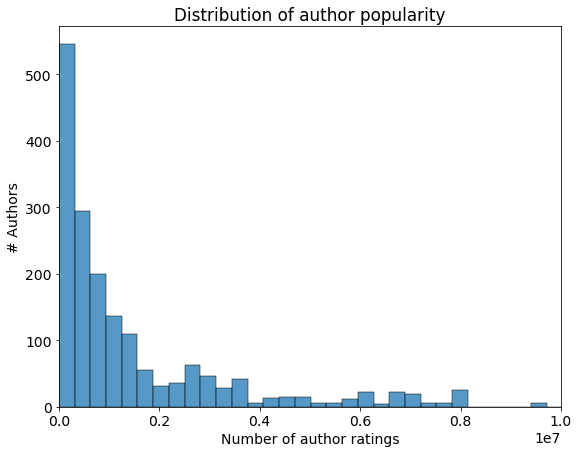

In [1135]:
plt.figure(figsize=(9,7))
plt.rc('font', size=14)
sns.histplot(data=sub_df, x='author_ratings')
plt.gca().set_xlim(0, 1E7)
plt.title('Distribution of author popularity')
plt.ylabel('# Authors')
plt.xlabel('Number of author ratings')

In [861]:
sorted_genres

Fiction                1592
Literature              954
Fantasy                 488
Young Adult Fiction     364
Romance                 347
                       ... 
Judaica                   0
Ethics                    0
Foreign Film              0
Management                0
Childrens Video           0
Length: 98, dtype: int64

In [1063]:
genre_df_demand = df[list(sorted_genres.index)][df.demand<100]
genre_df_demand = genre_df_demand.apply(lambda x: x * df.demand)
genre_df_demand.head(10)
genre_demand_totals = genre_df_demand.sum().sort_values(ascending=False)
genre_demand_totals

Fiction                9315.0
Literature             5867.0
Fantasy                3465.0
Thriller               1785.0
Young Adult Fiction    1771.0
                        ...  
Documentary               0.0
Feature Film              0.0
Short Film                0.0
Cooking & Food            0.0
Childrens Video           0.0
Length: 98, dtype: float64

In [946]:
genre_df_counts = df[list(sorted_genres.index)][df.demand<100]
genre_df_counts = genre_df_counts.sum()
genre_df_counts.replace(0, 1)

Fiction                1566
Literature              936
Fantasy                 481
Young Adult Fiction     361
Romance                 340
                       ... 
Judaica                   1
Ethics                    1
Foreign Film              1
Management                1
Childrens Video           1
Length: 98, dtype: int64

In [948]:
ranked_genres = (genre_demand_totals / genre_df_counts)

Text(0.5, 1.0, 'Demand normalized by number of titles')

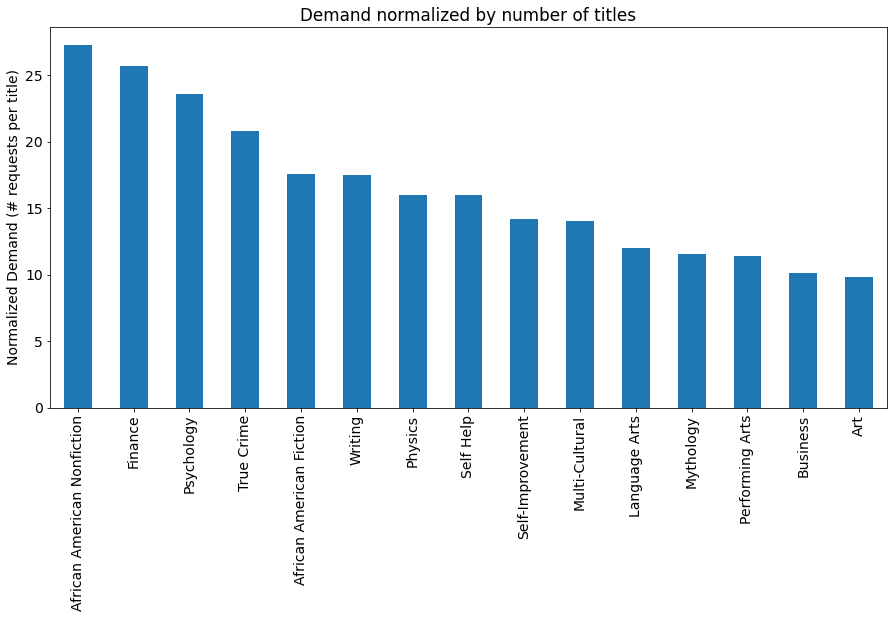

In [1108]:
plt.figure(figsize=(15,7))
plt.rc('font', size=14)
ranked_genres.sort_values(ascending=False)[:15].plot.bar()
plt.ylabel('Normalized Demand (# requests per title)')
plt.title('Demand normalized by number of titles')


Text(0, 0.5, 'Demand')

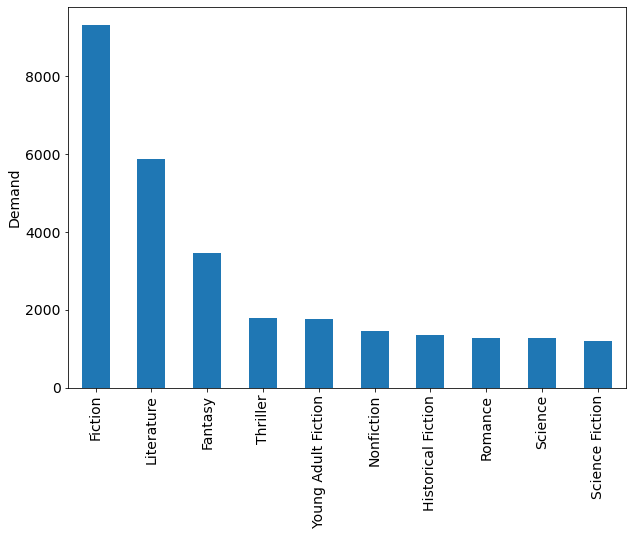

In [964]:
plt.figure(figsize=(10,7))
plt.rc('font', size=14)
genre_demand_totals[:10].plot.bar()
plt.ylabel('Demand')

In [1069]:
# genre_demand_totals['cumpercentage'] = np.nan
genre_demand_totals = pd.DataFrame(genre_demand_totals, columns = ['demand'])
# genre_demand_totals['cumpercentage'] = genre_demand_totals["demand"].cumsum()/genre_demand_totals["genre_demand_totals"].sum()*100
genre_demand_totals['cumpercentage'] = genre_demand_totals["demand"].cumsum()/genre_demand_totals["demand"].sum()*100
genre_demand_totals

,demand,cumpercentage
Fiction,9315.0,23.820483
Literature,5867.0,38.823680
Fantasy,3465.0,47.684439
Thriller,1785.0,52.249073
Young Adult Fiction,1771.0,56.777906
...,...,...
Documentary,0.0,100.000000
Feature Film,0.0,100.000000
Short Film,0.0,100.000000
Cooking & Food,0.0,100.000000


In [1076]:
genre_demand_totals.iloc[:10]

,demand,cumpercentage
Fiction,9315.0,23.820483
Literature,5867.0,38.823680
Fantasy,3465.0,47.684439
Thriller,1785.0,52.249073
Young Adult Fiction,1771.0,56.777906
Nonfiction,1444.0,60.470528
Historical Fiction,1361.0,63.950901
Romance,1272.0,67.203682
Science,1269.0,70.448792
Science Fiction,1188.0,73.486766


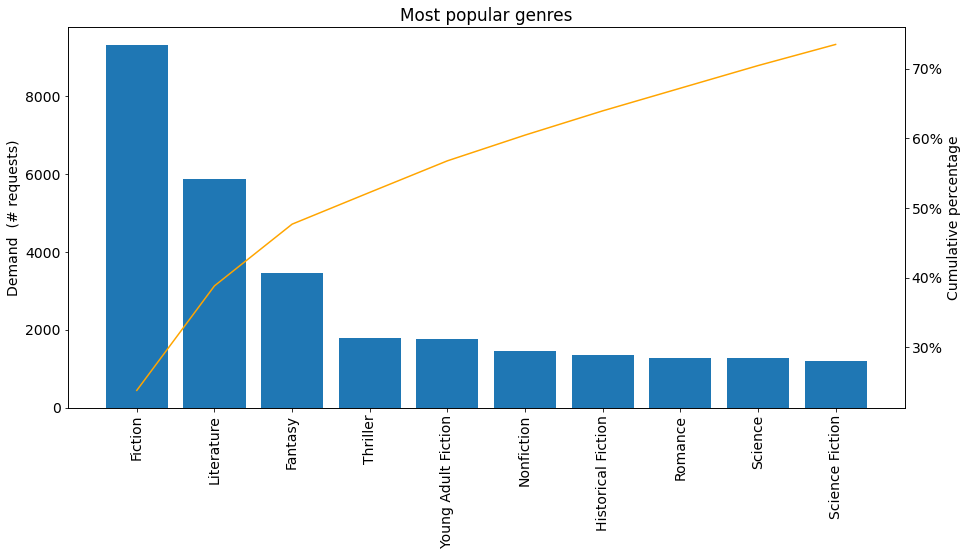

In [1109]:
genre_demand_totals = genre_demand_totals.iloc[:10]
from matplotlib.ticker import PercentFormatter
plt.rc('font', size=14)

fig, ax = plt.subplots(figsize=(15,7))

ax.bar(genre_demand_totals.index, genre_demand_totals["demand"])#, color="C0")
plt.ylabel('Demand  (# requests)')
plt.xticks(rotation=90)

ax2 = ax.twinx()
ax2.plot(genre_demand_totals.index, genre_demand_totals["cumpercentage"], color="orange")#, marker="D", ms=7)
ax2.yaxis.set_major_formatter(PercentFormatter())

plt.ylabel('Cumulative percentage')
ax.tick_params(axis="y")#, colors="C0")
ax2.tick_params(axis="y")#, colors="C1")
plt.title('Most popular genres')
plt.show()

In [850]:
X_author = sub_df_norm['author_ratings'][sub_df_norm['author_ratings'] < float('inf')]
X_author.sort_values(ascending=False)


4854    29764387.0
4855    29764387.0
1164    29743518.0
1114    29743518.0
581     29742596.0
           ...    
5085          10.0
5228           9.0
5229           9.0
4611           8.0
2718           5.0
Name: author_ratings, Length: 1800, dtype: float64

In [852]:
y_author = sub_df_norm['demand'][sub_df_norm['author_ratings'] < float('inf')]
X_author = pd.DataFrame(np.array(X_author).reshape(-1,1), columns = ['author_ratings'])
lr_a = LinearRegression()
lr_a.fit(X_author, y_author)
lr_a.score(X_author, y_author)

0.029820061847249724

In [858]:
y_author.sort_values(ascending=False)

3409    99
4014    79
2846    77
1114    77
5263    76
        ..
4262     0
4263     0
4270     0
4272     0
5267     0
Name: demand, Length: 1800, dtype: int64

In [807]:
sub_df_corr.columns

Index(['stars', 'number of ratings', 'is_series', 'is_ebook', 'Library copies',
       'author_stars', 'author_ratings', 'author_num_reviews',
       'author_distinct_works', 'age', 'Poetry', 'demand', 'movie_age',
       'number of ratings (norm)'],
      dtype='object')

In [808]:
sub_df_corr = sub_df_corr[['stars', 'number of ratings', 'is_series', 'is_ebook', 'author_stars', 'author_ratings',
                          'age', 'number of ratings (norm)', 'Library copies', 'demand']]

In [1129]:
sub_df_corr['popularity'] = sub_df_corr['number of ratings (norm)'] * sub_df_corr['stars']
sub_df_corr = sub_df_corr[['stars', 'number of ratings', 'is_series', 'is_ebook', 'author_stars', 'author_ratings',
                          'age', 'number of ratings (norm)', 'Library copies', 'popularity','demand']]

Text(0.5, 1.0, 'Correlation heatmap')

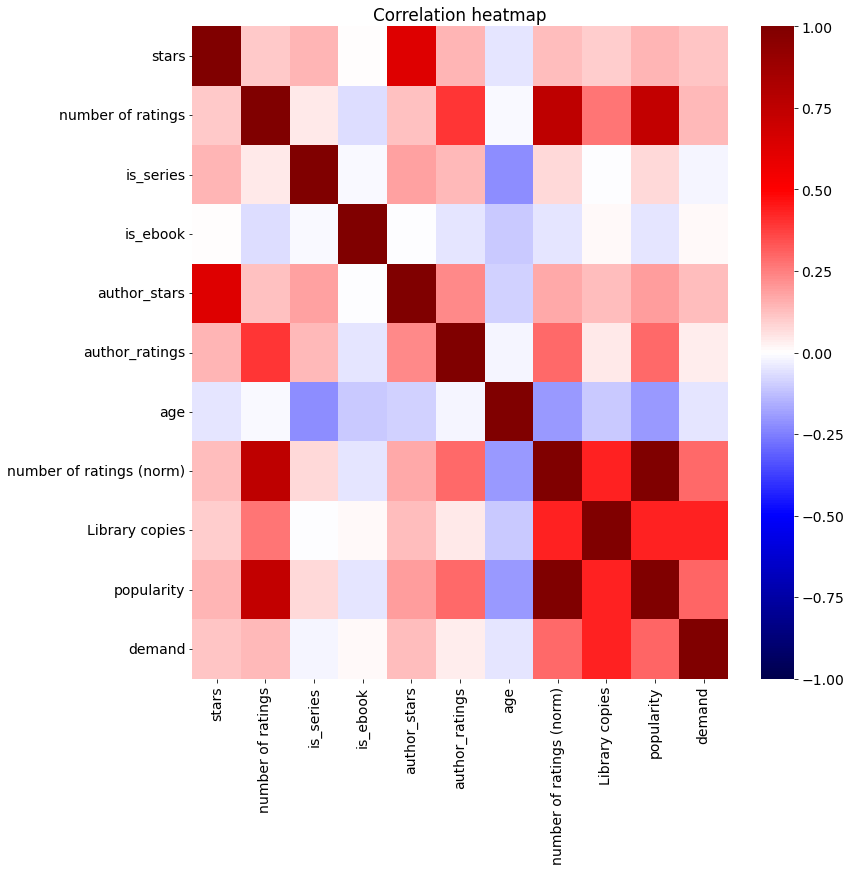

In [1130]:
plt.figure(figsize=(12, 12))
sns.heatmap(sub_df_corr.corr(), cmap='seismic', vmin=-1.0, vmax=1.0)
plt.title('Correlation heatmap')

In [804]:
sub_df_corr = sub_df.drop(columns=['Literature', 'Nonfiction', 'Young Adult Fiction',
       'Romance', 'Fiction', 'Fantasy','price', 'number of pages', 'LevScore_IMDB', 
       'People waiting in total'], errors='ignore')

In [805]:
sub_df_corr['number of ratings (norm)'] = sub_df_corr['number of ratings'] / sub_df_corr['age']

In [1131]:
sub_df_corr_correlation = sub_df_corr.corr()
sub_df_corr_correlation

,stars,number of ratings,is_series,is_ebook,author_stars,author_ratings,age,number of ratings (norm),Library copies,popularity,demand
stars,1.000000,0.107256,0.146307,0.001331,0.631766,0.142066,-0.046906,0.128427,0.095147,0.147683,0.116520
number of ratings,0.107256,1.000000,0.040408,-0.064041,0.124790,0.394630,-0.008117,0.751466,0.273254,0.740931,0.134551
is_series,0.146307,0.040408,1.000000,-0.011611,0.186254,0.136511,-0.219678,0.072946,-0.003085,0.071955,-0.017394
is_ebook,0.001331,-0.064041,-0.011611,1.000000,-0.001287,-0.052406,-0.101603,-0.049129,0.009459,-0.047960,0.008183
author_stars,0.631766,0.124790,0.186254,-0.001287,1.000000,0.227131,-0.093616,0.166418,0.131130,0.188802,0.130543
author_ratings,0.142066,0.394630,0.136511,-0.052406,0.227131,1.000000,-0.018918,0.293732,0.044514,0.294061,0.038196
age,-0.046906,-0.008117,-0.219678,-0.101603,-0.093616,-0.018918,1.000000,-0.197941,-0.107856,-0.197042,-0.051514
number of ratings (norm),0.128427,0.751466,0.072946,-0.049129,0.166418,0.293732,-0.197941,1.000000,0.432393,0.997824,0.289758
Library copies,0.095147,0.273254,-0.003085,0.009459,0.131130,0.044514,-0.107856,0.432393,1.000000,0.434452,0.437323
popularity,0.147683,0.740931,0.071955,-0.047960,0.188802,0.294061,-0.197042,0.997824,0.434452,1.000000,0.300767


In [471]:
sub_df_corr_correlation['norm_improv_factor'] = sub_df_corr_correlation['number of ratings (norm)']/sub_df_corr_correlation['number of ratings']

In [472]:
sub_df_corr_correlation.loc[['Library copies', 'demand'],['norm_improv_factor', 'number of ratings', 'number of ratings (norm)']]

,norm_improv_factor,number of ratings,number of ratings (norm)
Library copies,1.582388,0.273254,0.432393
demand,2.153515,0.134551,0.289758


Number of ratings may have a time dependency because the longer a book is in print, the more time reviewers have to rate the book. Normalizing by years in print would correct for the time effect. Normalizing improved the correlation between 60-100%. I cannot repeat the same normalization with author reputation because I would need to know the length of time an author has been listed on Goodreads which is data I do not have.